In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
%run functions.ipynb

In [3]:
start = '2021-01-01'
end   = '2024-01-01'
data = yf.Ticker('TSLA').history(start=start, end=end)
data.index=pd.to_datetime(data.index.date) #reindex removing hours
close=data.Close

In [4]:
def SMA(close, win_fast, win_slow, plot=False):


    sma_fast=close.rolling(window=win_fast).mean()
    sma_slow=close.rolling(window=win_slow).mean()

    position=pd.Series(index=close.index, dtype=float)
    position[sma_fast>=sma_slow]=1
    position[sma_fast<sma_slow]=-1
    #position=np.sign(position.diff())
    #position=position.replace(to_replace=0, method='ffill')
    df=pd.concat([close,position],axis=1, keys=['close','position'])

    df['log_ret']=log_ret(df.close)



    ####### compute returns ########
    rets=np.exp(log_ret(df.close).cumsum())
    strategy_rets=np.exp((log_ret(df.close)*df.position.shift(1)).cumsum()) #shift because we enter position after observing signal
    print('hold: ', rets[-1])
    print('strategy: ', strategy_rets[-1])




    ####### plots ########
    if plot==True:
        df.close.plot(figsize=(8,2),lw=0.4,color='green', label='stock')
        sma_fast.plot(color='red', lw=1, label='fast SMA')
        sma_slow.plot(color='blue', lw=1, label='slow SMA')

        (df.close[0]*strategy_rets).plot(lw=0.7, alpha=0.3, color='purple', label='strategy ret')
        plt.legend(loc='upper left',fontsize='x-small')

        ax2=plt.gca().twinx()
        position.shift(1).plot(ax=ax2,alpha=0.7,lw=0.3,color='k', label='trade')
        plt.legend(loc='lower left',fontsize='x-small')



win_fast=1,  win_slow=10: 6.7; win_fast=8, win_slow=21: 7.11

do it with EMA

In [5]:
SMA(close, 8, 21)

hold:  1.0214724951949443
strategy:  7.1142547461708165


hold:  0.7518807000521686
strategy:  4.224128633779292
hold:  1.346994059105867
strategy:  0.9241985536361734
hold:  1.0073573061274395
strategy:  1.1148181010490494


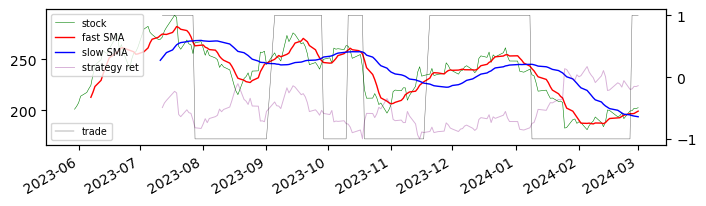

In [6]:
win_fast=7
win_slow=29
train,test=ordered_split([close],0.8)[0]
SMA(train, win_fast, win_slow)
SMA(test, win_fast, win_slow)


#test on new data
new = yf.Ticker('TSLA').history(start='2023-05-27', end='2024-03-03')
new.index=pd.to_datetime(new.index.date) #reindex removing hours
new_close=new.Close

SMA(new_close, win_fast, win_slow,plot=True)

Problem: when the price declines, by the time the fast mean has crossed the slow mean again, all the gains have been lost. Can we find a better (earlier) exit signal?